In [1]:
import tensorflow as tf
import gensim
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import random

Корпус с Wikipedia в качестве обучающих данных

In [2]:
wiki_texts = open('wiki_data.txt').read().split('\n')

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [3]:
from pymorphy2 import MorphAnalyzer

In [4]:
morph = MorphAnalyzer()
# предобработка -> токенизация + лемматизация
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    # лемматизируем с pymorphy
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return(tokens)

In [5]:
import pickle

texts_preprocessed = [preprocess(text) for text in wiki_texts]

In [6]:
with open('wiki_texts_preprocessed.pickle', 'wb') as handle:
    pickle.dump(texts_preprocessed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
vocab = Counter()

for text in wiki_texts:
    vocab.update(preprocess(text))

In [18]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [19]:
len(filtered_vocab)

7191

Создаем словарь с индексами слов

In [20]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    
id2word = {i:word for word, i in word2id.items()}

In [21]:
sentences = []

for text in wiki_texts:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

Создадим словарь из пар *id_слова + частота*, чтобы учитывать частоту слов при выборе отрицательных примеров для negative sampling:

In [22]:
filtered_vocab_counts = {}

for key in vocab.keys():
    if key in filtered_vocab:
        filtered_vocab_counts[key] = vocab[key]

In [23]:
list(filtered_vocab_counts.items())[150:155]

[('южный', 1100),
 ('побережье', 331),
 ('фамилия', 215),
 ('распространение', 196),
 ('российский', 1518)]

In [24]:
filtered_vocab_probs_ids= {}

n = len(filtered_vocab_counts)
for key in filtered_vocab_counts:
    if key in word2id.keys():
        filtered_vocab_probs_ids[word2id[key]] = filtered_vocab_counts[key]/n

In [25]:
list(filtered_vocab_probs_ids.items())[150:155]

[(5088, 0.15296898901404535),
 (1168, 0.046029759421499096),
 (547, 0.02989848421638159),
 (3123, 0.027256292587957167),
 (6154, 0.21109720483938257)]

### Skip Gram Negative Sampling

In [26]:
# skip gram, генерируем обучающие примеры батчами
def gen_batches_sg(sentences, window, batch_size=1000):
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]

                # задаем контекст, делим размер окна на 2 
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                for context_word in context:
                    # генерируем положительные примеры
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    # генерируем отрицательные примеры
                    X_target.append(word)    
                    # генерируем 50 рандомных индексов с учетом частот
                    id_based_on_frequency = random.choices(list(filtered_vocab_probs_ids.keys()), 
                                                           weights=filtered_vocab_probs_ids.values(), 
                                                           k=50)[np.random.randint(50)] # берем один рандомный индекс из 50-ти
                    X_context.append(id_based_on_frequency) 
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [27]:
inputs_target = tf.keras.layers.Input(shape=(1,)) # input для целевого слова
inputs_context = tf.keras.layers.Input(shape=(1,)) # input для контекстного слова


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

skipgram_neg_smp_model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
skipgram_neg_smp_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
skipgram_neg_smp_model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=2)

### CBOW negative sampling

In [28]:
# cbow 
def gen_batches_cbow(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                id_based_on_frequency = random.choices(list(filtered_vocab_probs_ids.keys()), 
                                                           weights=filtered_vocab_probs_ids.values(), 
                                                           k=50)[np.random.randint(50)]
                X_target.append(np.random.randint(id_based_on_frequency))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [29]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
4408/5000 [=========================>....] - ETA: 3:28 - loss: 0.4712 - accuracy: 0.6452

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [30]:
texts = [preprocess(text) for text in wiki_texts]

### Word2Vec

In [31]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             size=128, 
                             min_count=25, 
                             max_vocab_size=11000,
                             window=7,
                             iter=8,
                             sg=1,
                             hs=0,
                             negative=10,
                             sample=1e-4,
                             ns_exponent=0.5,
                             cbow_mean=1)

CPU times: user 2min 48s, sys: 230 ms, total: 2min 49s
Wall time: 58.1 s


In [32]:
w2v.wv.most_similar('земля')

[('вблизи', 0.5352714657783508),
 ('владение', 0.5176960229873657),
 ('сюда', 0.48518675565719604),
 ('территория', 0.47058215737342834),
 ('равнина', 0.4633858799934387),
 ('поселение', 0.45746898651123047),
 ('архипелаг', 0.45344778895378113),
 ('возвышенность', 0.4533337354660034),
 ('здесь', 0.4452474117279053),
 ('монастырский', 0.44440656900405884)]

In [ ]:
w2v.wv.most_similar('yt,j')

### FastText

In [ ]:
ft = gensim.models.FastText(texts, min_n=4, max_n=9)

In [ ]:
ft.wv.most_similar('небо')

[('небо»', 0.934395432472229),
 ('«небо', 0.8608723878860474),
 ('неборак', 0.7895488739013672),
 ('ямаска', 0.7811084985733032),
 ('скала', 0.7645103931427002),
 ('ряска', 0.7569539546966553),
 ('небраска', 0.7563798427581787),
 ('холмс', 0.7518442273139954),
 ('куколь', 0.7450626492500305),
 ('поверх', 0.7448087930679321)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

#### Предобработка

In [ ]:
data = pd.read_csv('labeled.csv')

In [ ]:
# берем предобработку из задания 1
data['norm_text'] = data.comment.apply(preprocess)

In [ ]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6309

In [ ]:
word2id2 = { 'PAD':0}

for word in filtered_vocab:
    word2id2[word] = len(word2id2)
id2word2 = {i:word for word, i in word2id2.items()}

Переводим слова в индексы

In [ ]:
X = []

for tokens in data['norm_text']:
    ids = [word2id2[token] for token in tokens if token in word2id2]
    X.append(ids)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

Разбиваем датасет на обучающую и тестовую выборки:

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
def classify_with_embeddings(word2id, emb_model, X_train, y_train, X_valid, y_valid):
  # создаем матрицу с векторными представлениями
    weights = np.zeros((len(word2id), 100))

    for word, i in word2id.items():
        if word == 'PAD':
            continue
        try:
            weights[i] = ft.wv[word]
      
      
        except KeyError:
            continue
            weights[i] = ft.wv['ллалалаллала']

    inputs = tf.keras.layers.Input(shape=(100,))

  # передаем матрицу в эмбединг слой
    embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
    mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  # обучаем модель
    model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)
  
    return model

In [ ]:
def plot_accuracy(model):
    print(model.history.history.keys())
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### FastText classifier

In [ ]:
fasttext_classifier = classify_with_embeddings(word2id2, ft, X_train, y_train, X_valid, y_valid)

In [ ]:
fasttext_classifier.history.history['accuracy'][29]

0.7227375507354736

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


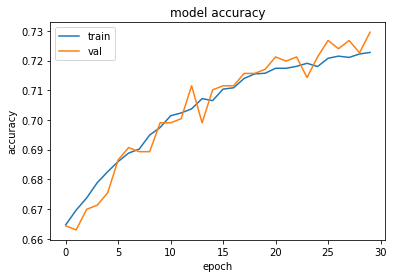

In [ ]:
plot_accuracy(fasttext_classifier)

#### Word2Vec Classifier

In [ ]:
word2vec_classifier = classify_with_embeddings(word2id2, w2v, X_train, y_train, X_valid, y_valid)

In [ ]:
word2vec_classifier.history.history['accuracy'][29]

0.7222262620925903

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


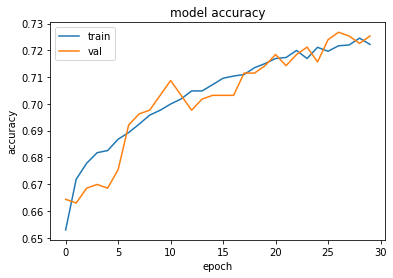

In [ ]:
plot_accuracy(word2vec_classifier)

#### CBOW Negative Sampling Classifier

In [ ]:
cbow_classifier = classify_with_embeddings(word2id2, model, X_train, y_train, X_valid, y_valid)

In [ ]:
cbow_classifier.history.history['accuracy'][29]

0.7225184440612793

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


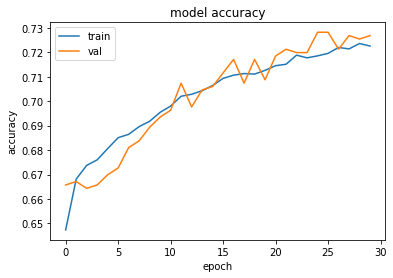

In [ ]:
plot_accuracy(cbow_classifier)